In [10]:
! pip install tensorflow_datasets
! pip install tensorflow 
! pip install tensorflow.keras

In [11]:


import tensorflow_datasets as tfds
import numpy as np
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
import time
import pandas as pd
from tensorflow.keras import Sequential
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.model_selection import KFold
import numpy as np

%matplotlib inline

In [12]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)

# List physical devices
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("🚀 GPU(s) detected!")
    for gpu in gpus:
        print(f" - {gpu}")
    print("TensorFlow will use the GPU by default when available.")
else:
    print("⚠️ No GPU detected. Using CPU only.")

⚠️ No GPU detected. Using CPU only.


In [13]:
# Load KMNIST from tensorflow_datasets
(ds_train, ds_test), ds_info = tfds.load(
    'kmnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

In [14]:
# Preprocessing function: flatten images and one-hot encode labels
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0         # Normalize to [0,1]
    image = tf.reshape(image, [-1])                    # Flatten to 784
    label = tf.one_hot(label, depth=10)                # One-hot encode
    return image, label

BATCH_SIZE = 256

ds_train = ds_train.map(preprocess).shuffle(10000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

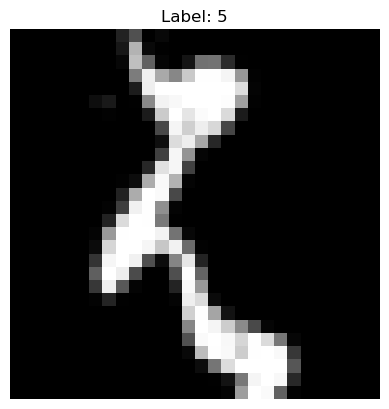

In [15]:
# Display one sample image from KMNIST (reshaped for visualization)

for image, label in ds_train.take(1):
    img = tf.reshape(image[0], (28, 28))  # Take the first image in the batch and reshape
    plt.imshow(img.numpy(), cmap='gray')
    plt.title(f"Label: {np.argmax(label[0].numpy())}")  # Show the class index
    plt.axis('off')
    plt.show()

In [16]:
# Prepare full dataset as numpy arrays for cross-validation
images = []
labels = []
results = []

for image, label in tfds.as_numpy(ds_train.unbatch()):
    images.append(image.flatten() / 255.0)
    labels.append(label) 
    
X = np.array(images, dtype=np.float32)
y = np.stack(labels).astype(np.float32)

# Learning rate scheduler
def scheduler(epoch, lr):
    return lr / np.sqrt(epoch + 1)

lr_callback = LearningRateScheduler(scheduler)

# K-Fold Cross-Validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_index, val_index) in enumerate(kf.split(X)):
    print(f"🔁 Fold {fold+1}/5")

    model = Sequential([
        Dense(128, activation='relu', input_shape=(784,)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(10, activation='softmax')
    ])
    
    # Optimizer setup
    optimizer = Adam(
        learning_rate=1e-3,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-7
        )

    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    start_time = time.time()
    
    model.fit(
        X[train_index], y[train_index],
        validation_data=(X[val_index], y[val_index]),
        epochs=10,
        batch_size=BATCH_SIZE,
        callbacks=[lr_callback],
        verbose=2
    )
    end_time = time.time()
    elapsed_time = end_time - start_time

    # Evaluate on validation set
    val_loss, val_accuracy = model.evaluate(X[val_index], y[val_index], verbose=0)

    # Store results
    results.append({
        'Fold': fold + 1,
        'Accuracy': val_accuracy,
        'Loss': val_loss,
        'Training Time (s)': elapsed_time
    })

# Create and display table
results_df = pd.DataFrame(results)
print(results_df)

🔁 Fold 1/5


c:\Users\helen\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
188/188 - 15s - 78ms/step - accuracy: 0.7217 - loss: 0.8738 - val_accuracy: 0.1978 - val_loss: 2.2308 - learning_rate: 0.0010
Epoch 2/10
188/188 - 14s - 74ms/step - accuracy: 0.8238 - loss: 0.5651 - val_accuracy: 0.5418 - val_loss: 1.8421 - learning_rate: 7.0711e-04
Epoch 3/10
188/188 - 14s - 72ms/step - accuracy: 0.8471 - loss: 0.4934 - val_accuracy: 0.8224 - val_loss: 0.8436 - learning_rate: 4.0825e-04
Epoch 4/10
188/188 - 13s - 72ms/step - accuracy: 0.8556 - loss: 0.4634 - val_accuracy: 0.8855 - val_loss: 0.4011 - learning_rate: 2.0412e-04
Epoch 5/10
188/188 - 14s - 75ms/step - accuracy: 0.8614 - loss: 0.4462 - val_accuracy: 0.8916 - val_loss: 0.3574 - learning_rate: 9.1287e-05
Epoch 6/10
188/188 - 14s - 73ms/step - accuracy: 0.8626 - loss: 0.4411 - val_accuracy: 0.8943 - val_loss: 0.3468 - learning_rate: 3.7268e-05
Epoch 7/10
188/188 - 14s - 75ms/step - accuracy: 0.8656 - loss: 0.4348 - val_accuracy: 0.8940 - val_loss: 0.3457 - learning_rate: 1.4086e-05
Epoch 8/10
188/18

In [18]:
#Now set up AdamW optimizer and run K-Fold Cross-Validation again
from tensorflow.keras.optimizers import AdamW

# reset results for AdamW
results = []
# Reset the Keras session to clear previous models
from tensorflow.keras import backend as K
K.clear_session()


# K-Fold Cross-Validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_index, val_index) in enumerate(kf.split(X)):
    print(f"🔁 Fold {fold+1}/5")

    model = Sequential([
        Dense(128, activation='relu', input_shape=(784,)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(10, activation='softmax')
    ])
    
    # Optimizer setup
    optimizer = AdamW(
        weight_decay=1e-4,  # Set weight decay for AdamW
        learning_rate=1e-3,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-7
        )

    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    start_time = time.time()
    
    model.fit(
        X[train_index], y[train_index],
        validation_data=(X[val_index], y[val_index]),
        epochs=10,
        batch_size=BATCH_SIZE,
        callbacks=[lr_callback],
        verbose=2
    )
    end_time = time.time()
    elapsed_time = end_time - start_time

    # Evaluate on validation set
    val_loss, val_accuracy = model.evaluate(X[val_index], y[val_index], verbose=0)

    # Store results
    results.append({
        'Fold': fold + 1,
        'Accuracy': val_accuracy,
        'Loss': val_loss,
        'Training Time (s)': elapsed_time
    })

# Create and display table
results_df = pd.DataFrame(results)
print(results_df)

🔁 Fold 1/5
Epoch 1/10
188/188 - 15s - 81ms/step - accuracy: 0.7184 - loss: 0.8859 - val_accuracy: 0.2137 - val_loss: 2.2083 - learning_rate: 0.0010
Epoch 2/10
188/188 - 15s - 81ms/step - accuracy: 0.8223 - loss: 0.5721 - val_accuracy: 0.7477 - val_loss: 1.7060 - learning_rate: 7.0711e-04
Epoch 3/10
188/188 - 15s - 81ms/step - accuracy: 0.8439 - loss: 0.5076 - val_accuracy: 0.8578 - val_loss: 0.7607 - learning_rate: 4.0825e-04
Epoch 4/10
188/188 - 15s - 80ms/step - accuracy: 0.8549 - loss: 0.4674 - val_accuracy: 0.8819 - val_loss: 0.4119 - learning_rate: 2.0412e-04
Epoch 5/10
188/188 - 15s - 80ms/step - accuracy: 0.8598 - loss: 0.4527 - val_accuracy: 0.8873 - val_loss: 0.3678 - learning_rate: 9.1287e-05
Epoch 6/10
188/188 - 15s - 80ms/step - accuracy: 0.8633 - loss: 0.4450 - val_accuracy: 0.8894 - val_loss: 0.3607 - learning_rate: 3.7268e-05
Epoch 7/10
188/188 - 15s - 80ms/step - accuracy: 0.8632 - loss: 0.4383 - val_accuracy: 0.8899 - val_loss: 0.3579 - learning_rate: 1.4086e-05
Epoch 